In [20]:
import numpy as np
import pandas as pd
from stocktrends import Renko
import statsmodels.api as sm
from alpha_vantage.timeseries import TimeSeries
import copy
import matplotlib.pyplot as plt
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)

In [11]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Adj Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Adj Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"],df["Signal"])

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [3]:
# Download historical data for DJI constituent stocks

tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]

In [5]:
ohlc_intraday = {} # directory with ohlc value for each stock            
ts = TimeSeries(key='25V9C3YS6OPO9YSE', output_format='pandas') # key=open(key_path,'r').read()

In [6]:
attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <=5:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        try:
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i],interval='5min', outputsize='full')[0]
            ohlc_intraday[tickers[i]].columns = ["Open","High","Low","Adj Close","Volume"]
            drop.append(tickers[i])      
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1

CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
V

In [15]:
drop

['MSFT', 'AAPL', 'FB', 'AMZN', 'INTC']

In [7]:
ohlc_intraday

{'MSFT':                          Open      High     Low  Adj Close  Volume
 date                                                              
 2021-05-06 20:00:00  249.5500  249.5500  249.55     249.55   353.0
 2021-05-06 19:55:00  249.4400  249.6700  249.44     249.67  1353.0
 2021-05-06 19:45:00  249.7001  249.7001  249.44     249.49  2311.0
 2021-05-06 19:30:00  249.6500  249.8400  249.65     249.84   405.0
 2021-05-06 19:20:00  249.7900  249.7900  249.79     249.79   200.0
 ...                       ...       ...     ...        ...     ...
 2021-04-08 04:25:00  251.8700  251.8700  251.87     251.87   290.0
 2021-04-08 04:20:00  251.7300  251.7300  251.73     251.73   523.0
 2021-04-08 04:15:00  252.0000  252.0000  252.00     252.00   662.0
 2021-04-08 04:10:00  252.3900  252.3900  252.39     252.39   511.0
 2021-04-08 04:05:00  252.0000  252.1300  252.00     252.13  1663.0
 
 [3431 rows x 5 columns],
 'AAPL':                        Open    High     Low  Adj Close   Volume
 date  

In [9]:
tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data
tickers

dict_keys(['MSFT', 'AAPL', 'FB', 'AMZN', 'INTC'])

In [12]:
################################Backtesting####################################

#Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["macd"]= MACD(ohlc_renko[ticker],12,26,9)[0]
    ohlc_renko[ticker]["macd_sig"]= MACD(ohlc_renko[ticker],12,26,9)[1]
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"],5)
    ohlc_renko[ticker]["macd_sig_slope"] = slope(ohlc_renko[ticker]["macd_sig"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

merging for  MSFT


<ipython-input-11-00a7507d78ff>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
<ipython-input-11-00a7507d78ff>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]


merging for  AAPL
merging for  FB
merging for  AMZN
merging for  INTC


In [13]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
                elif ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating daily returns for  MSFT
calculating daily returns for  AAPL
calculating daily returns for  FB
calculating daily returns for  AMZN
calculating daily returns for  INTC


In [14]:
ohlc_renko["AMZN"]

,Open,High,Low,Adj Close,Volume,Date,bar_num,macd,macd_sig,macd_slope,macd_sig_slope,ret
0,3307.00,3307.00,3305.00,3307.00,677.0,2021-05-06 20:00:00,1.0,NaN,NaN,0.000000,0.000000,0.000000
1,3305.00,3305.00,3305.00,3305.00,109.0,2021-05-06 19:55:00,1.0,NaN,NaN,0.000000,0.000000,0.000000
2,3306.00,3306.00,3306.00,3306.00,331.0,2021-05-06 19:50:00,1.0,NaN,NaN,0.000000,0.000000,0.000000
3,3308.99,3308.99,3308.99,3308.99,332.0,2021-05-06 19:40:00,1.0,NaN,NaN,0.000000,0.000000,0.000000
4,3306.00,3306.00,3306.00,3306.00,153.0,2021-05-06 19:30:00,1.0,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2675,3308.74,3308.74,3308.00,3308.00,430.0,2021-04-08 07:15:00,5.0,0.650601,-0.030491,39.882102,45.384416,-0.001135
2676,3306.20,3307.00,3305.00,3307.00,1818.0,2021-04-08 07:10:00,5.0,0.440905,0.063788,5.760254,45.448571,-0.000302
2677,3311.00,3312.00,3308.05,3308.05,1877.0,2021-04-08 07:05:00,5.0,0.355350,0.122100,-37.911737,44.540894,0.000318
2678,3310.00,3310.00,3310.00,3310.00,327.0,2021-04-08 06:30:00,5.0,0.439826,0.185646,-42.360565,43.769927,0.000589


In [17]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
print("CAGR =",CAGR(strategy_df))
print("Sharpe =", sharpe(strategy_df,0.025))
print("Max DrawDown =", max_dd(strategy_df))  

CAGR = -0.2933649998862251
Sharpe = -5.015813386071428
Max DrawDown = 0.06677935663202765


<AxesSubplot:>

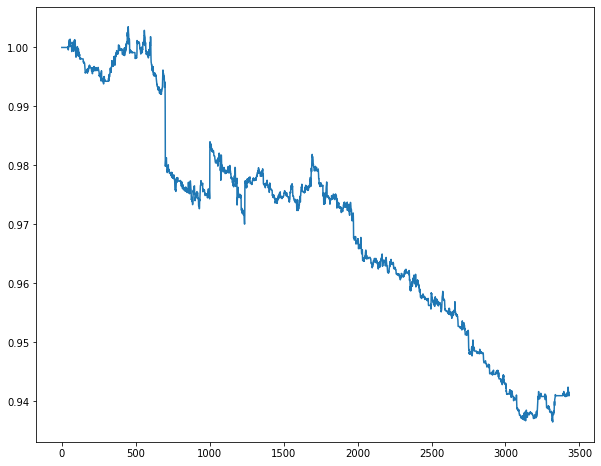

In [22]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [19]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC


,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.277478,-2.557636,0.063805
AAPL,-0.149938,-1.651016,0.054177
FB,-0.180314,-1.295836,0.069763
AMZN,-0.636956,-3.165016,0.147169
INTC,-0.260318,-2.430084,0.074943
